In [ ]:
# This notebooks implements a realNVP model for variational inference.
# The target distribution is D=16 dimensional; the coordinates are independent
# and each coordinate is distributed to a double well potential.

In [1]:
# autorelad when changes are made
%load_ext autoreload
%autoreload 2

In [2]:
# add parent directory to path for imports
import sys, os
sys.path.append(os.path.abspath('..'))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import time

from nflows.builders import build_realnvp
from nflows.distributions import StandardNormal, DiagNormal


In [4]:
# Initialize PRNG key
key = jax.random.PRNGKey(0)

In [30]:

# create a RealNVP flow
dim_input = 16
num_layers = 8
hidden_sizes = [512, 512]

flow, params = build_realnvp(
    key=key,
    dim=dim_input,
    num_layers=num_layers,
    hidden_sizes=hidden_sizes,
    max_log_scale = 3.0,
    use_permutation = False,
    use_linear = True,
    trainable_base=True,  # let the base adapt a bit
    activation=jax.nn.tanh
)


In [31]:
# sample from the flow
n_samples = 10_000
x_samples = flow.sample(params, key, shape=(n_samples,))

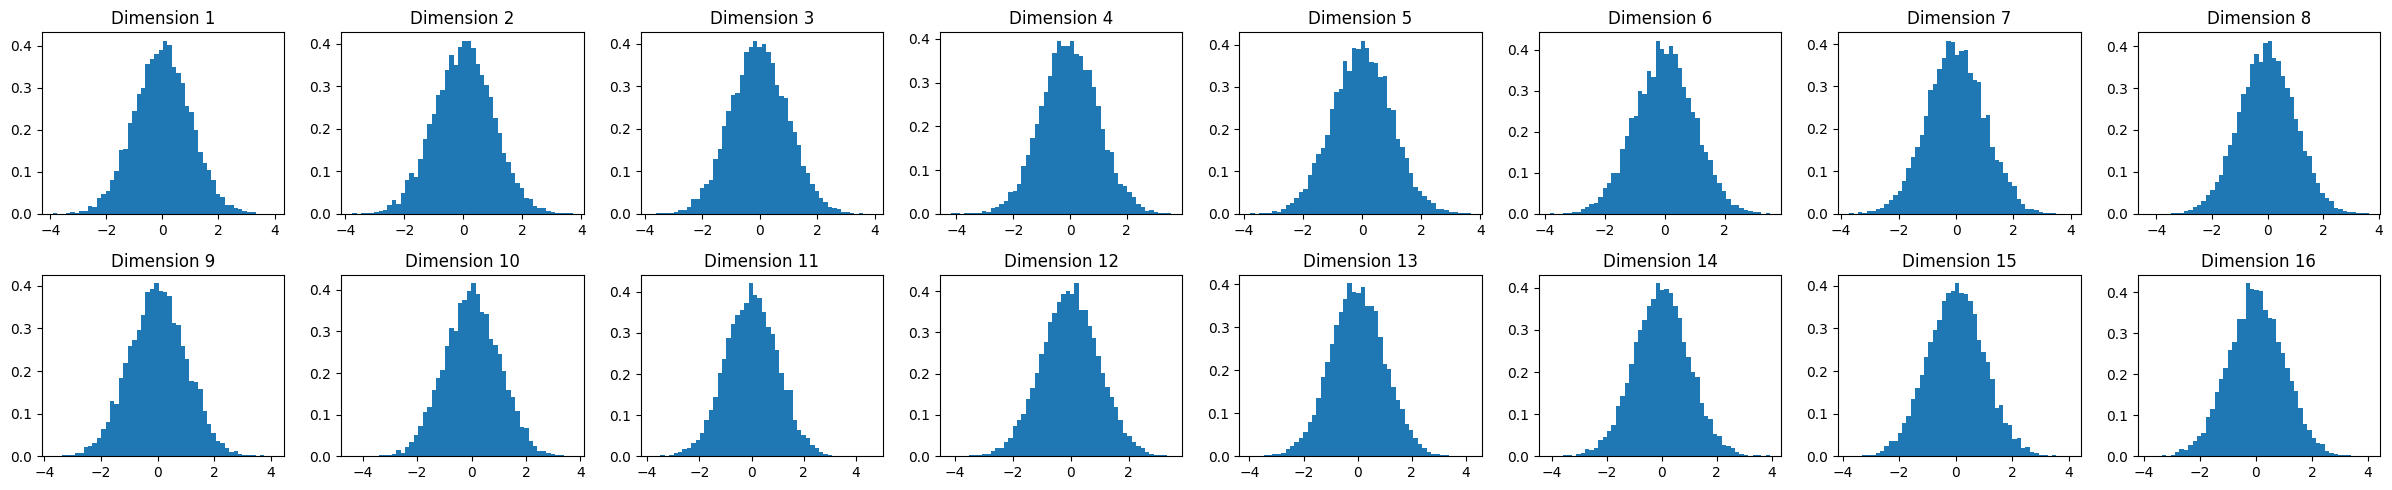

In [32]:
# for each dimension, plot histogram of samples
# make sure that at initialization, the samples look like standard normal
# this is because the flow is initialized to be close to identity for stable training
ncol = 8
nrow = dim_input // ncol + int(dim_input % ncol > 0)
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*2.5))
for i in range(dim_input):
    ax = axes[i // ncol, i % ncol]
    ax.hist(x_samples[:, i], bins=50, density=True)
    ax.set_title(f"Dimension {i+1}")
plt.tight_layout()

In [33]:
# Define the target distribution: 1D double-well potential for each dimension
def marginal_double_well_potential(x: jnp.ndarray) -> jnp.ndarray:
    """
    1D double-well potential U(x) = (x^2 - 1)^2.

    x: array of shape (...,)
    returns: array of shape (...,)
    """
    return 0.5 * (x**2 - 4.0)**2

def double_well_potential(x: jnp.ndarray) -> jnp.ndarray:
    """
    Double-well potential in multiple dimensions: each dimension is independent
    and follows the 1D double-well potential.
    """
    return jnp.sum(marginal_double_well_potential(x), axis=-1)
    

def log_target(x: jnp.ndarray) -> jnp.ndarray:
    """
    log target
    """
    # compute double well potential
    U = double_well_potential(x)
    return -U


In [34]:
# estimate normalization constant via numerical integration
# 1D log(Z) = log int exp(log_target(x)) dx
from scipy.integrate import quad
x_min, x_max = -10.0, 10.0
# integrate in 1D
Z = quad(lambda x: np.exp(-marginal_double_well_potential(x)), x_min, x_max)[0]
# since dimensions are independent, total log(Z) = dim * log(Z_1D)
log_Z_normalization_true = np.log(Z) * dim_input  # since independent dimensions
print(f"Estimated log normalization constant: {log_Z_normalization_true:.4f}")

Estimated log normalization constant: 4.0570


In [35]:
def reverse_kl_loss(params, key, n_samples, sticking_the_landing=True) -> jnp.ndarray:
    """
    Monte Carlo estimate of KL(q || π) up to an additive constant:

      L(params) = E_{x ~ q_params}[log q_params(x) - log π̃(x)]

    where log π̃ is the unnormalized log density.
    """
    params_stop_grad = jax.tree_util.tree_map(jax.lax.stop_gradient, params)
    key_sample, _ = jax.random.split(key)
    
    # ** Sticking the landing: **
    # allows to (sometimes/slightly) reduce the noise of the gradient estimator near convergence
    #
    # reference:
    # ==========
    # "Sticking the Landing: Simple, Lower-Variance Gradient Estimators for Variational Inference"
    # by Roeder, Wu, and Duvenaud, NeurIPS 2017
    if sticking_the_landing:
      x = flow.sample(params, key_sample, shape=(n_samples,))    
      log_q = flow.log_prob(params_stop_grad, x)
    else:
      # standard score function estimator
      x, log_q = flow.sample_and_log_prob(params, key_sample, shape=(n_samples,))    
    
    # compute log unnormalized target
    log_pi_tilde = log_target(x)
    
    # compute the ELBO
    elbo = jnp.mean(log_pi_tilde - log_q)
    
    # the loss is negative ELBO
    return - elbo

In [37]:
# for stability, use gradient clipping
learning_rate = 1e-5
clip_norm = 5.0

optimizer = optax.chain(
    optax.clip_by_global_norm(clip_norm),
    optax.adam(learning_rate),
)

opt_state = optimizer.init(params)


In [38]:
def train_step(params, opt_state, key, n_samples):
    """
    basic training step:
    1. compute loss and gradients
    2. update parameters using optimizer
    3. return updated parameters and optimizer state
    """
    loss, grads = jax.value_and_grad(reverse_kl_loss)(params, key, n_samples)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# JIT compile the train step with n_samples as static argument because it affects the shape of arrays
train_step = jax.jit(train_step, static_argnames=("n_samples",))

In [39]:
params_train = params.copy()
key, key_train = jr.split(key)

In [40]:
# number of train iterations
niters = 10_000

# number of monte carlo samples per gradient estimate
n_samples = 10_000

loss_history = []


# do one step to trigger JIT compilation before timing
if True:
    key_train, key_step = jax.random.split(key_train)
    params_train, opt_state, loss = train_step(params_train, opt_state, key_step, n_samples)

time_start = time.time()
for step in range(niters):
    key_train, key_step = jax.random.split(key_train)
    params_train, opt_state, loss = train_step(params_train, opt_state, key_step, n_samples)
    loss_history.append(float(loss))

    if step % (niters // 20) == 0:
        time_since_start = time.time() - time_start
        time_per_iter = time_since_start / (step + 1)
        print(f"[{step:4d}/{niters}]: reverse-KL loss ≈ {float(loss):.4f}, time: {time_since_start:.1f}s, per 1k iter: {time_per_iter*1000:.4f}s")

[   0/10000]: reverse-KL loss ≈ 65.1859, time: 0.0s, per 1k iter: 24.4572s
[ 500/10000]: reverse-KL loss ≈ 58.7871, time: 7.9s, per 1k iter: 15.7888s
[1000/10000]: reverse-KL loss ≈ 8.6417, time: 16.0s, per 1k iter: 15.9357s
[1500/10000]: reverse-KL loss ≈ 7.8120, time: 24.0s, per 1k iter: 15.9963s
[2000/10000]: reverse-KL loss ≈ 7.5387, time: 32.0s, per 1k iter: 16.0020s
[2500/10000]: reverse-KL loss ≈ 7.3408, time: 40.1s, per 1k iter: 16.0410s
[3000/10000]: reverse-KL loss ≈ 7.2932, time: 48.2s, per 1k iter: 16.0698s
[3500/10000]: reverse-KL loss ≈ 7.2449, time: 56.3s, per 1k iter: 16.0903s
[4000/10000]: reverse-KL loss ≈ 7.1589, time: 64.4s, per 1k iter: 16.1073s
[4500/10000]: reverse-KL loss ≈ 7.1202, time: 72.5s, per 1k iter: 16.1159s
[5000/10000]: reverse-KL loss ≈ 7.0454, time: 80.7s, per 1k iter: 16.1296s
[5500/10000]: reverse-KL loss ≈ 7.0514, time: 88.8s, per 1k iter: 16.1433s
[6000/10000]: reverse-KL loss ≈ 7.0252, time: 96.9s, per 1k iter: 16.1513s
[6500/10000]: reverse-KL 

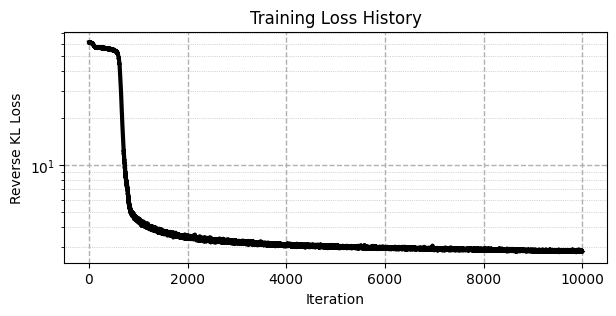

In [41]:
loss_history = np.array(loss_history)
negative_elbo = loss_history - log_Z_normalization_true


plt.figure(figsize=(7,3))
plt.plot(negative_elbo, c='black', lw=3)
# y on log scale
plt.yscale("log")

# add grid
plt.grid(which='major', linestyle='--', linewidth=1)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Reverse KL Loss")
plt.show()

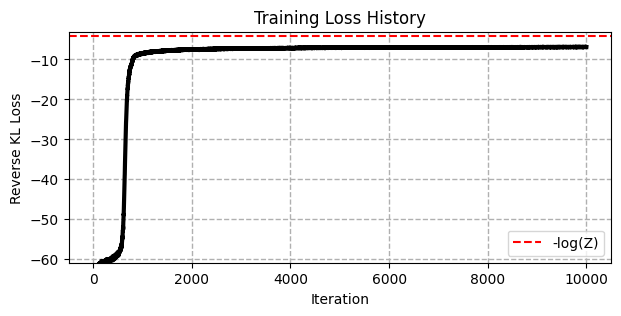

In [42]:
loss_history = np.array(loss_history)
elbo = -loss_history

plt.figure(figsize=(7,3))
plt.plot(elbo, c='black', lw=3)
# plot horizontal line at the true ELBO value (negative log normalization constant)
plt.axhline(y=-log_Z_normalization_true, color='red', linestyle='--', label='-log(Z)')
plt.legend()

# compute bottom 5% quantile of loss to set y-axis limit
bottom_5_percentile = np.percentile(elbo, 2)
plt.ylim(bottom_5_percentile, -log_Z_normalization_true + 1.0)

# add grid
plt.grid(which='major', linestyle='--', linewidth=1)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Reverse KL Loss")
plt.show()

In [43]:
# define a sampling function & jit compile it
def sample_flow(params, key, n_samples):
    return flow.sample(params, key, shape=(n_samples,))
sample_flow = jax.jit(sample_flow, static_argnames=("n_samples",))

In [44]:
# generate many samples from trained flow
n_samples = 10000
key, key_samples = jax.random.split(key)
# x_samples = flow.sample(params_train, key_samples, shape=(n_samples,))
x_samples = sample_flow(params_train, key_samples, n_samples)

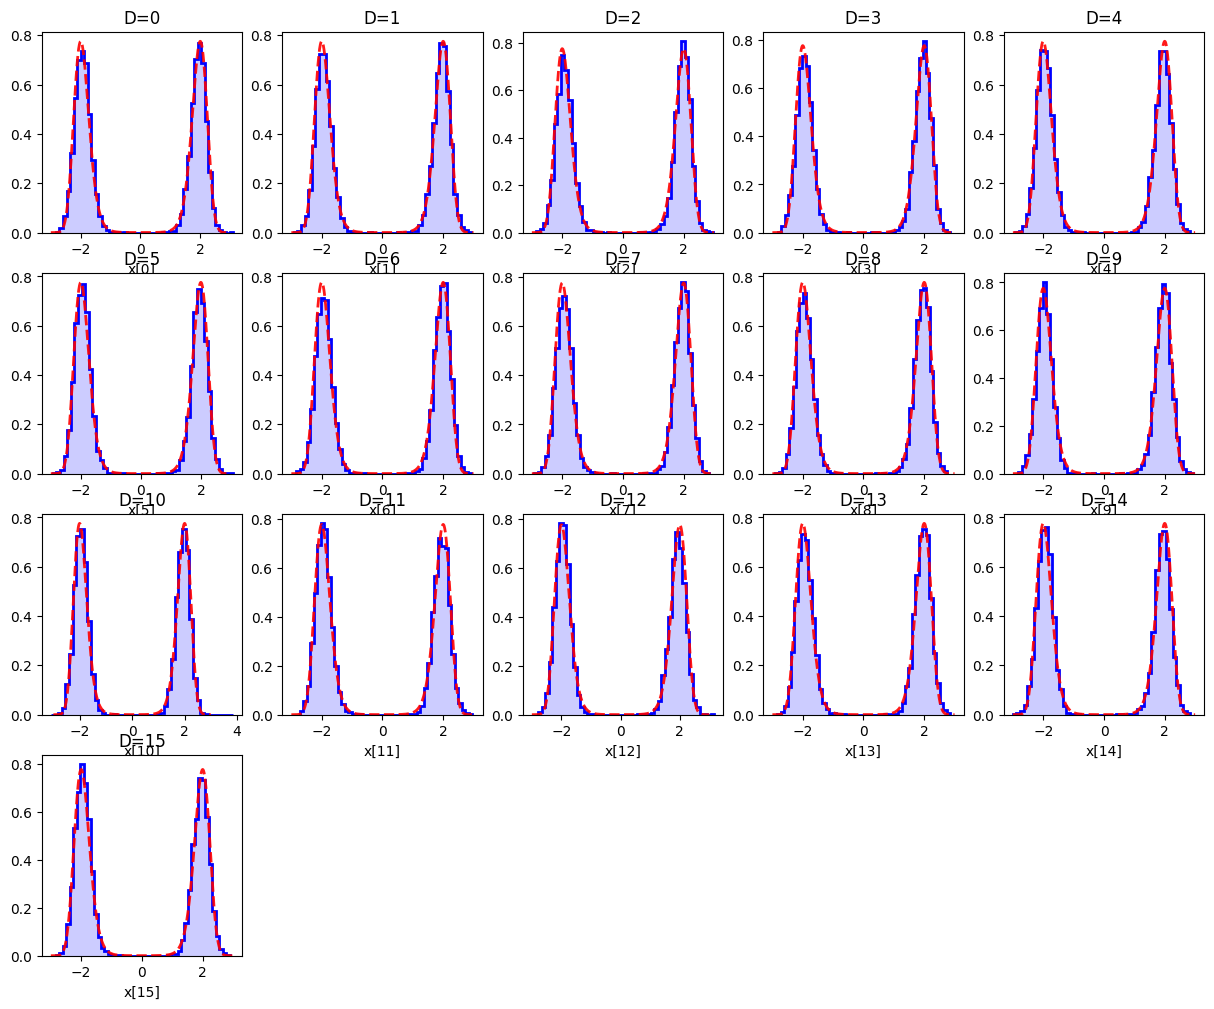

In [45]:
n_col = 5
n_rows = int(dim_input / n_col)+1
plt.figure(figsize=(n_col*3, n_rows*3))

for d in range(dim_input):
    plt.subplot(n_rows, n_col, d+1)
    plt.hist(x_samples[:, d], bins=50, density=True, histtype="step", linewidth=2, color='blue')
    # fill with light color
    plt.hist(x_samples[:, d], bins=50, density=True, histtype="stepfilled", alpha=0.2, color='blue')
    plt.title(f"D={d}")
    plt.xlabel(f"x[{d}]")
    

    # superpose the true density
    xarr = jnp.linspace(-3, 3, 1000)
    proba = jnp.exp(log_target(jnp.stack([xarr, jnp.zeros_like(xarr)], axis=-1)))
    proba /= jnp.trapezoid(proba, xarr)  # normalize
    plt.plot(xarr, proba, 'r--', lw=2, label='True density', alpha=0.9)
    #plt.legend()